# **Aprendizaje por Refuerzo: Q-learning**

In [1]:
# Hiperparámetros de Q-learning:
# alpha: constante de aprendizaje (0,1)
# gamma: factor de descuento (0,1)

# Ganancia descontada en tiempo=t:
# r(t) + gamma*r(t+1) + gamma^2*r(t+2) + gamma^3*r(t+3) + ...

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [3]:
# Laberinto 1D de 5 posiciones:
# S0 (izquierda del todo), S1, S2, S3, S4 (derecha del todo)

In [4]:
N_STATES = 5 # número de habitaciones en el laberinto 1D
ACTIONS  = ['left', 'right']

### **Modelización del entorno**

In [5]:
class persona:
  def __init__(self, edad=10, nombre=""): # parámetros del usuario
    self.edad = edad # me los copio internamente
    self.nombre = nombre
  def cumple_anyos(self):
    self.edad = self.edad + 1

In [6]:
x = persona(edad=18, nombre="Juan")
y = persona(edad=1, nombre="Ana")

In [7]:
x.nombre, x.edad

('Juan', 18)

In [8]:
y.nombre, y.edad

('Ana', 1)

In [9]:
x.cumple_anyos()

In [10]:
x.nombre, x.edad

('Juan', 19)

In [11]:
y.nombre, y.edad

('Ana', 1)

In [12]:
class Env:
  def __init__(self, n_states=5):
    self.n_states = n_states
    self.reset()

  def reset(self):
    self.S = 0
    self.t = 0 # número de steps ocurridos

  def display(self):
    aux = ["-"]*self.n_states + ["T"]
    if self.S != -1:
      aux[self.S] = "o"
    print("Total steps: {}".format(self.t))
    print("".join(aux))

  def step(self, action):
    if self.S == -1: # estado terminal
      return self.S, 0, True

    self.t += 1
    if action == "left":
      if self.S == 0:
        #return self.S, 0, False
        self.S = self.n_states - 1
        return self.S, 0, False
      else:
        self.S -= 1
        return self.S, 0, False
    else: # right
      if self.S == (self.n_states - 1): # estoy en la última habitación
        self.S = -1 # estado terminal, ya hemos acabado
        return self.S, 1, True
      else:
        self.S += 1
        return self.S, 0, False

###Agente con comportamiento aleatorio

In [13]:
np.random.choice(ACTIONS)

'right'

In [14]:
entorno = Env(N_STATES)
entorno.display()
for i in range(100):
  entorno.step(np.random.choice(ACTIONS))
  entorno.display()

Total steps: 0
o----T
Total steps: 1
-o---T
Total steps: 2
o----T
Total steps: 3
----oT
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total steps: 4
-----T
Total step

In [15]:
class RandomAgent:
  def __init__(self):
    return
  def choose_action(self):
    return np.random.choice(ACTIONS)

In [16]:
# Un episodio (o "juego")
entorno = Env(N_STATES)
agente  = RandomAgent()
entorno.display()

fin = False
while not fin:
  action = agente.choose_action()
  S_new, r, fin = entorno.step(action)
  entorno.display()

Total steps: 0
o----T
Total steps: 1
-o---T
Total steps: 2
o----T
Total steps: 3
-o---T
Total steps: 4
--o--T
Total steps: 5
-o---T
Total steps: 6
o----T
Total steps: 7
-o---T
Total steps: 8
--o--T
Total steps: 9
-o---T
Total steps: 10
o----T
Total steps: 11
-o---T
Total steps: 12
o----T
Total steps: 13
----oT
Total steps: 14
---o-T
Total steps: 15
----oT
Total steps: 16
-----T


In [17]:
n_episodios = 1000
gamma = 0.9
duracion_episodios    = []
ganancias_descontadas = []

entorno = Env(N_STATES)
agente  = RandomAgent()

for episodio in range(n_episodios):
  # Un episodio (o "juego")
  #print()
  #print("EPISODIO", episodio+1)
  entorno.reset()
  #entorno.display()

  fin = False
  ganancia_descontada_partida = 0
  aux = 1
  while not fin:
    action = agente.choose_action()
    S_new, r, fin = entorno.step(action)
    ganancia_descontada_partida += aux*r
    #entorno.display()
    aux *= gamma

  duracion_episodios.append(entorno.t)
  ganancias_descontadas.append(ganancia_descontada_partida)


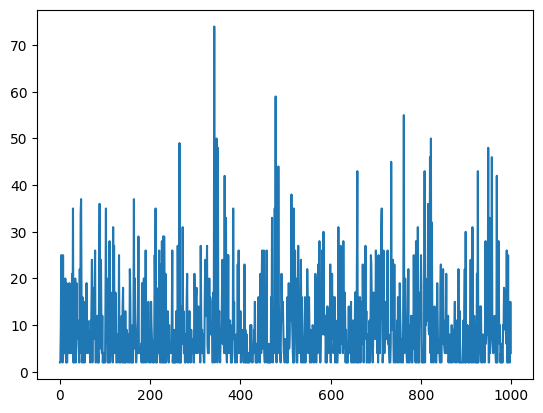

In [18]:
plt.plot(duracion_episodios);

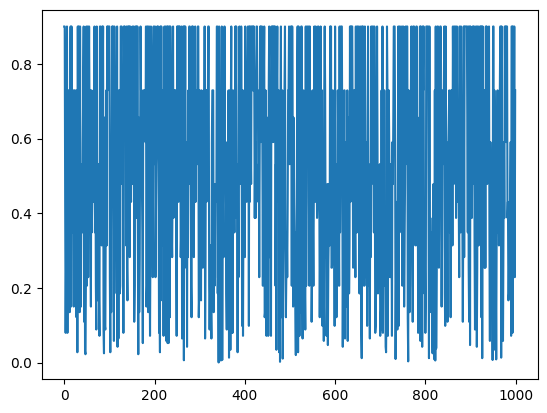

In [19]:
plt.plot(ganancias_descontadas);

### **Agente Q-learning**

In [20]:
class QAgent:
  def __init__(self,
               gamma,   # "factor de descuento"
               alpha,   # tasa de aprendizaje
               epsilon, # tasa de exploración
               n_states, # número de estados del entorno
               actions # listado de acciones posibles
               ):
    self.gamma = gamma
    self.alpha = alpha
    self.epsilon = epsilon
    self.n_states = n_states
    self.actions = actions.copy()
    self.Q_table = pd.DataFrame(np.zeros((n_states, len(actions))),
                                columns=actions)

  def choose_action(self, state):
    if np.random.rand() < self.epsilon: # se explora
      return np.random.choice(self.actions)
    else: # se sigue la tabla Q (acción con mayor valoración)
      valoraciones_acciones = self.Q_table.iloc[state]
      if (valoraciones_acciones==0).all():
        return np.random.choice(self.actions)
      else:
        return valoraciones_acciones.idxmax() # columna con mayor valoración

  def update_table(self, S_old, action, S_new, r):
    Q_sa = self.Q_table.loc[S_old,action]
    if S_new != -1:
      max_Q_sa_prima = self.Q_table.iloc[S_new].max()
      delta_Q_sa = self.alpha*(r+self.gamma*max_Q_sa_prima - Q_sa)
      self.Q_table.loc[S_old,action] += delta_Q_sa
    else: # S_new es terminal
      delta_Q_sa = self.alpha*(r - Q_sa)
      self.Q_table.loc[S_old,action] += delta_Q_sa

In [21]:
np.random.rand()

0.49327241683376644

In [22]:
lista1 = [1,2,3]
lista2 = lista1.copy()
lista1[0] = 10
print(lista2)

[1, 2, 3]


In [23]:
n_episodios = 1000
gamma = 0.9
duracion_episodios    = []
ganancias_descontadas = []

entorno = Env(N_STATES)
agente  = QAgent(alpha=0.1, gamma=0.9, epsilon=1,
                 n_states=N_STATES, actions=ACTIONS)

for episodio in range(n_episodios):
  # Un episodio (o "juego")
  #print()
  #print("EPISODIO", episodio+1)
  entorno.reset()
  #entorno.display()

  fin = False
  ganancia_descontada_partida = 0
  aux = 1
  while not fin:
    S_old = entorno.S
    action = agente.choose_action(S_old)
    #print("Acción elegida:", action)
    S_new, r, fin = entorno.step(action)
    agente.update_table(S_old, action, S_new, r)
    #display(agente.Q_table)

    ganancia_descontada_partida += aux*r
    #entorno.display()
    aux *= gamma

  duracion_episodios.append(entorno.t)
  ganancias_descontadas.append(ganancia_descontada_partida)

  #input("Introduce enter")


### Aprendizaje de agente Q-learning con acciones completamente aleatorias

In [24]:
display(agente.Q_table)

left  right
0  0.900  0.729
1  0.810  0.729
2  0.729  0.810
3  0.729  0.900
4  0.810  1.000

In [25]:
0.6561*0.9

0.5904900000000001

In [26]:
plt.plot(duracion_episodios);

In [27]:
plt.plot(ganancias_descontadas);

In [32]:
# "TEST":
# Un episodio (o "juego")

entorno.reset()
agente.epsilon = 0
entorno.S = 1
entorno.display()
print()

fin = False
while not fin:
  action = agente.choose_action(entorno.S)
  print("Acción elegida:", action)
  S_new, r, fin = entorno.step(action)
  entorno.display()
  print()

Total steps: 0
-o---T

Acción elegida: left
Total steps: 1
o----T

Acción elegida: left
Total steps: 2
----oT

Acción elegida: right
Total steps: 3
-----T

